# Plot ROC Curves for Structure Damage Classification with CAF, dCAF, and dNBR
## Plot ROC curves to evaluate CAF, dCAF, and dNBR for classifying structures in the Eaton Fire area as (1) Destroyed or (0) No Damage.
### Building polygons: OpenStreetMap shapefiles downloaded from [here](https://download.geofabrik.de/north-america/us/california/socal.html)
### Structure damage: DINS database [here](https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::cal-fire-damage-inspection-dins-data/explore?location=34.211734%2C-118.040860%2C11.86)
#### *Only* structures labeled either “Not Damaged” or “Destroyed” by DINS are included in this analysis. Structures labeled  “Affected” or “Minor Damage” are excluded.

Total structures loaded: 14945
Structures after clipping to raster extent: 14942

Number of NaN values before cleaning:
  DamageCode: 0
  dCAF_Median: 18
  CAF_Median: 0
  dNBR_Median: 18

Structures included in final analysis: 14924
dCAF ROC Analysis:
AUC: 0.8765
Youden’s J: 0.6153 at threshold 0.1577
    TPR: 0.7954, FPR: 0.1801
Min Distance to (0,1): 0.2724 at threshold 0.1557
    TPR: 0.7990, FPR: 0.1839


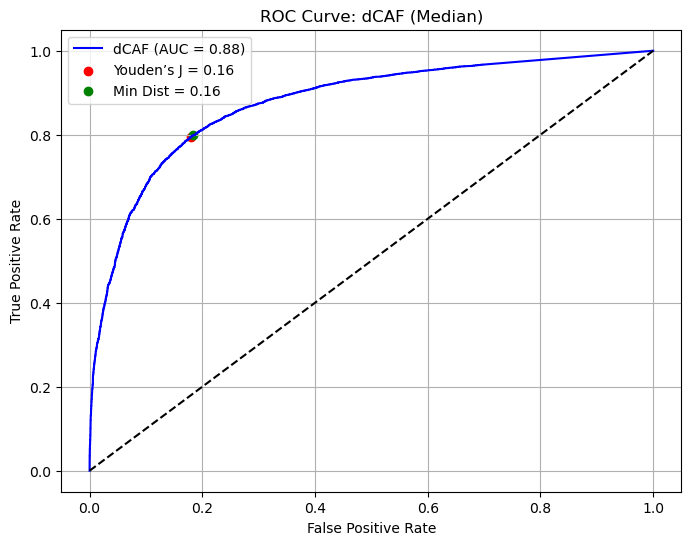

CAF ROC Analysis:
AUC: 0.8909
Youden’s J: 0.6638 at threshold 0.6601
    TPR: 0.8205, FPR: 0.1568
Min Distance to (0,1): 0.2383 at threshold 0.6598
    TPR: 0.8213, FPR: 0.1576


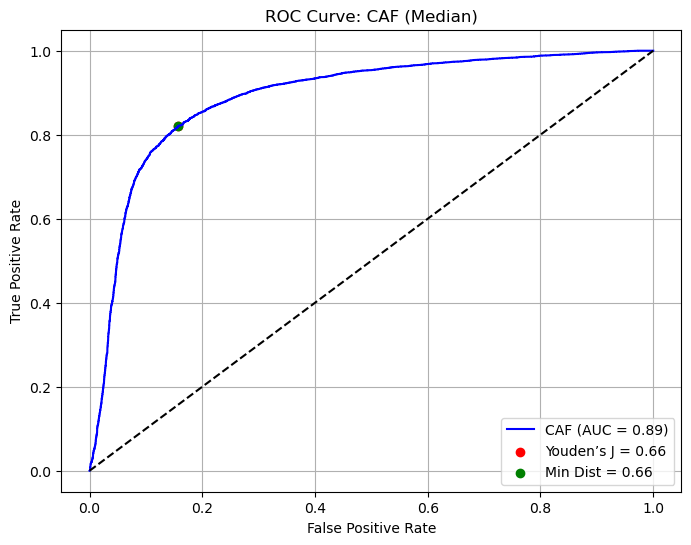

dNBR ROC Analysis:
AUC: 0.8512
Youden’s J: 0.5994 at threshold 0.1099
    TPR: 0.8038, FPR: 0.2044
Min Distance to (0,1): 0.2834 at threshold 0.1099
    TPR: 0.8038, FPR: 0.2044


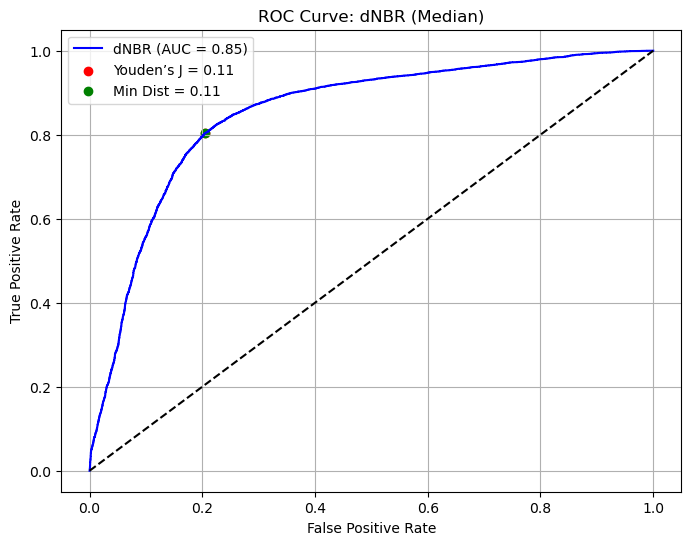

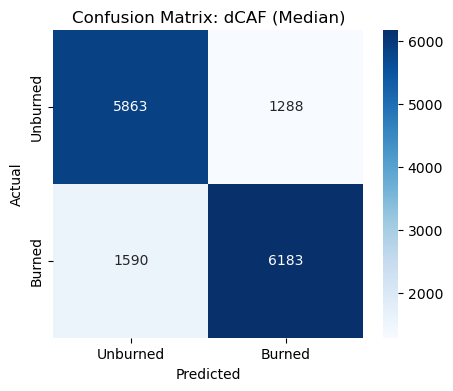


Classification Report for dCAF (Median):

              precision    recall  f1-score   support

    Unburned       0.79      0.82      0.80      7151
      Burned       0.83      0.80      0.81      7773

    accuracy                           0.81     14924
   macro avg       0.81      0.81      0.81     14924
weighted avg       0.81      0.81      0.81     14924



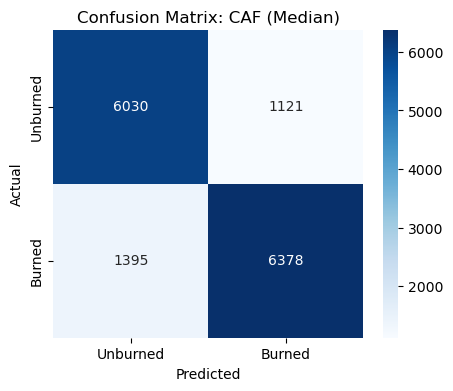


Classification Report for CAF (Median):

              precision    recall  f1-score   support

    Unburned       0.81      0.84      0.83      7151
      Burned       0.85      0.82      0.84      7773

    accuracy                           0.83     14924
   macro avg       0.83      0.83      0.83     14924
weighted avg       0.83      0.83      0.83     14924



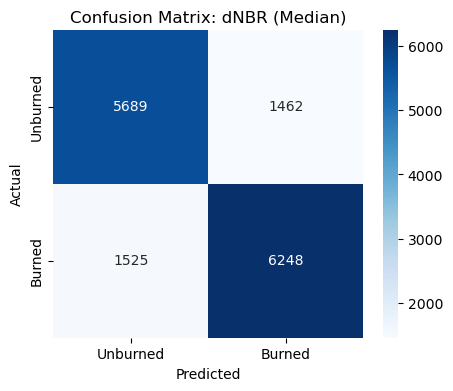


Classification Report for dNBR (Median):

              precision    recall  f1-score   support

    Unburned       0.79      0.80      0.79      7151
      Burned       0.81      0.80      0.81      7773

    accuracy                           0.80     14924
   macro avg       0.80      0.80      0.80     14924
weighted avg       0.80      0.80      0.80     14924



In [1]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# ------------------------------
# Load Data
# ------------------------------

# Load structure polygons
structures = gpd.read_file("/Volumes/One_Touch/Palisades_Eaton_Fire_ArcGIS/Structures_EatonFire/DINS_building_SpatialJoin.shp")

# Load rasters 
tif_path_dcaf = "/Volumes/GEOG/dNBR_eaton/dCAF_pre-post-fire_Eaton-masked-export.tif"
tif_path_caf = "/Volumes/One_Touch/Palisades_Eaton_Fire_ArcGIS/dCAF/charash_2025-01-16T19_52_46Z-to-2025-01-16T20_31_28Z.tif"
tif_path_dnbr = "/Volumes/GEOG/dNBR_eaton/dNBR_pre-post-fire_866nm_2198nm_Eaton-masked-export.tif"

with rasterio.open(tif_path_dcaf) as src:
    raster_bounds = src.bounds
    raster_bbox = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame({"geometry": [raster_bbox]}, crs=structures.crs)

# Clip structures to raster extent (but do NOT buffer)
structures_clipped = gpd.clip(structures, raster_gdf)

# ------------------------------
# Zonal Stats: Median
# ------------------------------

# dNBR
with rasterio.open(tif_path_dnbr) as src:
    dnbr_nodata = src.nodata
dnbr_stats = zonal_stats(
    structures_clipped, tif_path_dnbr,
    stats="median", geojson_out=True,
    nodata=dnbr_nodata
)
structures_clipped["dNBR_Median"] = [stat["properties"]["median"] for stat in dnbr_stats]

# CAF
with rasterio.open(tif_path_caf) as src:
    caf_nodata = src.nodata
caf_stats = zonal_stats(
    structures_clipped, tif_path_caf,
    stats="median", geojson_out=True,
    nodata=caf_nodata
)
structures_clipped["CAF_Median"] = [stat["properties"]["median"] for stat in caf_stats]

# dCAF
with rasterio.open(tif_path_dcaf) as src:
    dcaf_nodata = src.nodata
dcaf_stats = zonal_stats(
    structures_clipped, tif_path_dcaf,
    stats="median", geojson_out=True,
    nodata=dcaf_nodata
)
structures_clipped["dCAF_Median"] = [stat["properties"]["median"] for stat in dcaf_stats]

# ------------------------------
# Inspect and Clean NaNs
# ------------------------------

print(f"Total structures loaded: {len(structures)}")
print(f"Structures after clipping to raster extent: {len(structures_clipped)}")

# Count NaNs
print("\nNumber of NaN values before cleaning:")
print("  DamageCode:", structures_clipped["DamageCode"].isna().sum())
print("  dCAF_Median:", structures_clipped["dCAF_Median"].isna().sum())
print("  CAF_Median:", structures_clipped["CAF_Median"].isna().sum())
print("  dNBR_Median:", structures_clipped["dNBR_Median"].isna().sum())

# Drop rows with any NaNs
clean_structures = structures_clipped.dropna(subset=["DamageCode", "dCAF_Median", "CAF_Median", "dNBR_Median"])

print(f"\nStructures included in final analysis: {len(clean_structures)}")

# Extract ground reference
y_true = clean_structures["DamageCode"].astype(int)

# ------------------------------
# ROC + Optimal Thresholds
# ------------------------------

def analyze_metric(y_true, y_scores, label):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Youden’s J statistic
    j_scores = tpr - fpr
    youden_index = np.argmax(j_scores)
    threshold_youden = thresholds[youden_index]
    
    # Distance to (0,1)
    distances = np.sqrt((1 - tpr)**2 + fpr**2)
    min_dist_index = np.argmin(distances)
    threshold_dist = thresholds[min_dist_index]
    
    # Print detailed results
    print(f"{label} ROC Analysis:")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Youden’s J: {j_scores[youden_index]:.4f} at threshold {threshold_youden:.4f}")
    print(f"    TPR: {tpr[youden_index]:.4f}, FPR: {fpr[youden_index]:.4f}")
    print(f"Min Distance to (0,1): {distances[min_dist_index]:.4f} at threshold {threshold_dist:.4f}")
    print(f"    TPR: {tpr[min_dist_index]:.4f}, FPR: {fpr[min_dist_index]:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[youden_index], tpr[youden_index], color='red', label=f"Youden’s J = {threshold_youden:.2f}")
    plt.scatter(fpr[min_dist_index], tpr[min_dist_index], color='green', label=f"Min Dist = {threshold_dist:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {label} (Median)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return threshold_youden, threshold_dist


# Analyze dCAF
threshold_dcaf_youden, threshold_dcaf_dist = analyze_metric(y_true, clean_structures["dCAF_Median"], "dCAF")

# Analyze CAF
threshold_caf_youden, threshold_caf_dist = analyze_metric(y_true, clean_structures["CAF_Median"], "CAF")

# Analyze dNBR
threshold_dnbr_youden, threshold_dnbr_dist = analyze_metric(y_true, clean_structures["dNBR_Median"], "dNBR")

# ------------------------------
# Evaluate Classifications
# ------------------------------

def evaluate_model(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Unburned", "Burned"], yticklabels=["Unburned", "Burned"])
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(f"\nClassification Report for {label}:\n")
    print(classification_report(y_true, y_pred, target_names=["Unburned", "Burned"]))

# Evaluate using Youden’s J thresholds
y_pred_dcaf_youden = (clean_structures["dCAF_Median"] >= threshold_dcaf_youden).astype(int)
y_pred_caf_youden = (clean_structures["CAF_Median"] >= threshold_caf_youden).astype(int)
y_pred_dnbr_youden = (clean_structures["dNBR_Median"] >= threshold_dnbr_youden).astype(int)

# Evaluate using Min Distance thresholds
y_pred_dcaf_dist = (clean_structures["dCAF_Median"] >= threshold_dcaf_dist).astype(int)
y_pred_caf_dist = (clean_structures["CAF_Median"] >= threshold_caf_dist).astype(int)
y_pred_dnbr_dist = (clean_structures["dNBR_Median"] >= threshold_dnbr_dist).astype(int)

# Evaluate Model

y_pred_dcaf = y_pred_dcaf_youden
y_pred_caf = y_pred_caf_youden
y_pred_dnbr = y_pred_dnbr_youden

evaluate_model(y_true, y_pred_dcaf, "dCAF (Median)")
evaluate_model(y_true, y_pred_caf, "CAF (Median)")
evaluate_model(y_true, y_pred_dnbr, "dNBR (Median)")


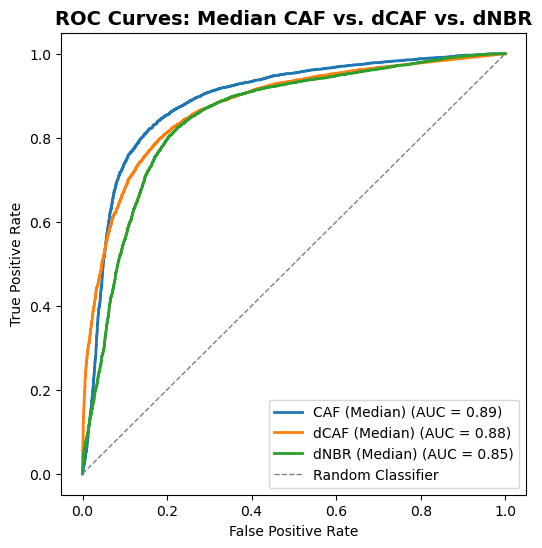

In [2]:
# Plot figure for paper

def plot_combined_roc(y_true, y_scores_dict, title="Combined ROC Curve"):
    """
    Plot multiple ROC curves on the same plot.

    Parameters:
    - y_true: Ground reference binary labels
    - y_scores_dict: Dictionary where keys are labels and values are prediction scores
    - title: Title of the plot
    """
    plt.figure(figsize=(6, 6))

    for label, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

    # Add diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random Classifier")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(loc="lower right")
    #plt.grid(True)
    plt.show()

plot_combined_roc(
    y_true,
    {
        "CAF (Median)": clean_structures["CAF_Median"],
        "dCAF (Median)": clean_structures["dCAF_Median"],
        "dNBR (Median)": clean_structures["dNBR_Median"]
    },
    title="ROC Curves: Median CAF vs. dCAF vs. dNBR"
)
